# Inspect the spectra in the data cube
- Here, the example focuses on RCW 79
- Specifically, the goal is to inspect the data to see if Gaussian fitting is not too strongly affected by misrepresentation

To assess whether GMM models is not affected by misrepresentation, individual velocity channels will be inspected. Specifically, their intensity probability distribution covering the full spatial map will be plotted.

In [1]:
import numpy as np
import astropy.io.fits as pyfits

import matplotlib.pyplot as plt
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1 import make_axes_locatable

from sklearn.decomposition import PCA

In [2]:
import velocity_axis_datacube as vax

In [3]:
#### user input ####

## Input for the data file
path_file = 'data/'
name_file = 'RCW79_CII_PCA_20_8_0p5_clean.fits'

## information for the observational information
noise_rms_obs = 0.6 ## K
unit_intensity = "T$_{mb}$ (K)"
unit_z_axis = "v (km s$^{-1}$)"

## velocity information
min_v = -70.
max_v = -20.

## the spatial region with data
x_min, x_max = 15, 175
y_min, y_max = 15, 175

## A list of the velocities that we want to investigate
vel_list = [-60., -48., -44., -35.]
vel_combs_list = [[0,1], [1,2], [0,3]] ## list of the indices in vel_list that will be investigated with 2D histograms

####################

In [4]:
## open the fits file and collect the data and header information
hdu = pyfits.open(path_file + name_file)
hdu.info()
data = hdu[0].data
header = hdu[0].header

## store the spectral information (in km/s)
dv = 0.001*header['CDELT3']
crval = 0.001*header['CRVAL3']
crpix = header['CRPIX3']

Filename: data/RCW79_CII_PCA_20_8_0p5_clean.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      42   (188, 188, 160)   float32   


In [5]:
## Create the velocity array necessary for plotting
vel_arr = vax.create_velocity_array(vax.pixel_to_vel(0, crval, dv, crpix), vax.pixel_to_vel(data.shape[0], crval, dv, crpix), dv)

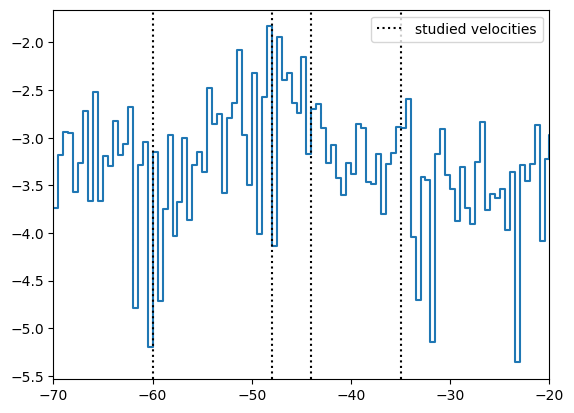

In [6]:
## plot the average spectrum of the region
plt.step(vel_arr, np.nanmin(data, axis = (1,2)))
plt.xlim([min_v, max_v])

## plot vertical lines that show the location of the considered velocities
for vel in vel_list:
    plt.axvline(x = vel, color = "k", linestyle = ":")
plt.plot([],[],"k:", label = "studied velocities")

plt.legend()
plt.show()

In [7]:
## Extract the intensity data for each velocity slice and store it in a list
data_channel_list = []
for vel in vel_list:
    ## Get the pixel corresponding to the considered velocity and extract the data slice
    pix = vax.vel_to_pixel(vel, crval, dv, crpix)
    data_slice = data[pix:pix+1,:,:].ravel()
    
    ## remove all nans from the data
    data_slice = data_slice[~np.isnan(data_slice)]
    
    ## add the result to the list
    data_channel_list.append(data_slice)


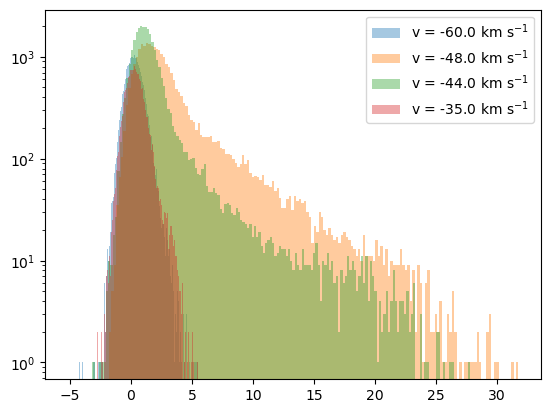

In [8]:
## plot the intensity histograms of the intensity data for each considered velocity
for vel, data_slice in zip(vel_list, data_channel_list):
    plt.hist(data_slice, bins = int(np.sqrt(len(data_slice))), label = r'v = {vel:.1f} km s$^{{-1}}$'.format(vel = vel), alpha = 0.4)
    
plt.yscale('log') 
plt.legend()
plt.show()

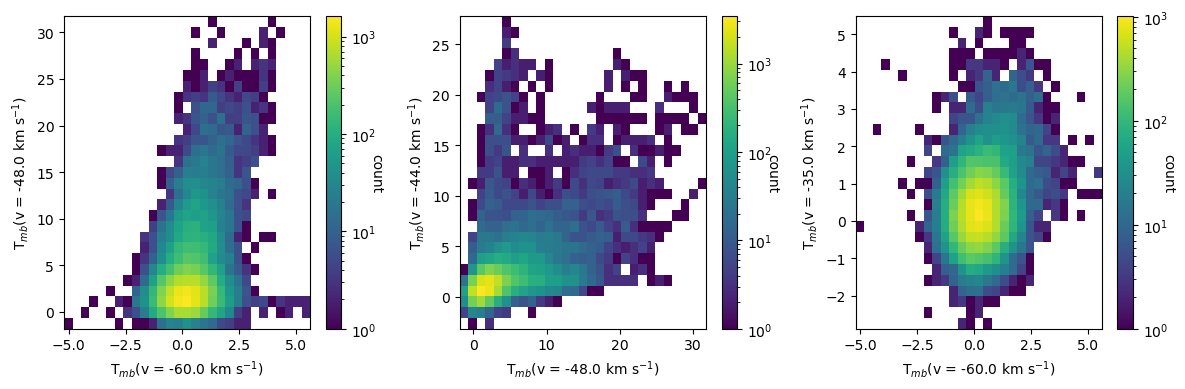

In [9]:
## plot 2D distributions
fig, axs = plt.subplots(nrows = 1, ncols = 3, figsize = (12, 4))
for idx, comb in enumerate(vel_combs_list):
    temp_im = axs[idx].hist2d(data_channel_list[comb[0]], data_channel_list[comb[1]], bins = int((len(data_channel_list[comb[0]]))**(0.33)), norm = colors.LogNorm())
    
    ## set labels
    axs[idx].set_xlabel(r'T$_{{mb}}$(v = {vel:.1f} km s$^{{-1}}$)'.format(vel = vel_list[comb[0]]))
    axs[idx].set_ylabel(r'T$_{{mb}}$(v = {vel:.1f} km s$^{{-1}}$)'.format(vel = vel_list[comb[1]]))
    
    ## add the colorbar
    cbar = fig.colorbar(temp_im[3], ax = axs[idx], orientation='vertical')
    cbar.set_label("count", labelpad = 5.,rotation = 270.)

plt.tight_layout()
plt.show()

## PCA analysis
To explore the presence of multiple relatively Gaussian distributions in the N-dimensional velocity-space used for the GMM analysis

In [10]:
#### User input ####
num_pca_comps = 3 ## The number of PCA components to be determined

In [11]:
## limit the data to the preset velocity range
z_b, z_e = vax.vel_to_pixel(min_v, crval, dv, crpix), vax.vel_to_pixel(max_v, crval, dv, crpix)
data_cut = data[z_b:z_e, y_min:y_max, x_min:x_max]

In [12]:
## perform PCA for the desired number of components
pca_comps = PCA(n_components = num_pca_comps)
print(data_cut.shape)
data_pca = np.reshape(data_cut, (data_cut.shape[0], -1))
print(data_pca.shape)
data_pca = data_pca.T
print(data_pca.shape)

(100, 160, 160)
(100, 25600)
(25600, 100)


In [13]:
## perform PCA fitting and perform the dimensionality reduction
pca_values = pca_comps.fit_transform(data_pca)

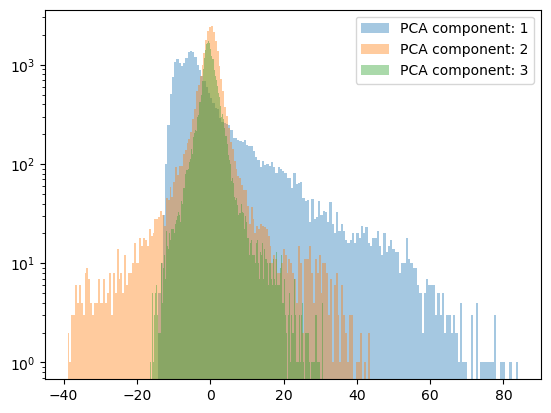

In [14]:
## study the histograms for the new pca reduced data
for idx, vals in enumerate(pca_values.T):
    plt.hist(vals, bins = int(np.sqrt(len(vals))), label = r'PCA component: {num}'.format(num = idx+1), alpha = 0.4)

plt.yscale('log') 
plt.legend()
plt.show()

# MAKE 2D HISTOGRAM PLOTS?